Trap Depth Calculations

In [1]:
import numpy as np
import scipy.constants as sc
from typing import Union

import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
def to_freq_ang(wavelength: float) -> float:
    """Converts a wavelength to its angular frequency using the formula 
       omega = 2*pi*c / lambda

    Args:
        wavelength (float): Wavelength [nm]

    Returns:
        float: Angular frequency in s^-1
    """

    # Converts a wavelength in nanometers of light to radians
    return (2*np.pi*sc.speed_of_light*1e9)/(wavelength)

In [3]:
def alpha(wavelength: float) -> complex:
    """Calculates the polarizability alpha using equation (8) from the Grimm review paper

    Args:
        wavelength (float): wavelength [nm]

    Returns:
        complex: Complex polarizability alpha
    """
    # Units = (A^2s^4)/(kg rad)
    # Use Equation (8)

    # https://jet.physics.ncsu.edu/techdocs/pdf/PropertiesOfLi.pdf

    omega_0       = to_freq_ang(wavelength = 671)
    omega         = to_freq_ang(wavelength = wavelength)
    gamma_omega_0 = 36.898e6  
    # Line width of the transition (We are only interested in the damping there)

    result  = 6 * np.pi * sc.epsilon_0 * (sc.speed_of_light**3)
    result *= gamma_omega_0 / (omega_0**2)
    result /= complex(omega_0**2 - omega**2, - (omega**3/omega_0**2)*gamma_omega_0)

    return result


In [4]:
def potential(intensity: Union[float, np.ndarray], wavelength: float) -> Union[float, np.ndarray]:
    """Calculates the dipole potential using equation (2) of the Grimms Review Paper

    Args:
        intensity (float): Intensity   [W/m^2]
        wavelength (float): Wavelength [nm]

    Returns:
        float: Potential [J]
    """
    
    # Equation (2) of Grimm
    _alpha = alpha(wavelength = wavelength)

    U_dip  = - np.real(_alpha) * intensity
    U_dip /= 2 * sc.epsilon_0 * sc.speed_of_light

    return U_dip

In [5]:
def trap_temperature(trap_depth: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """Converts a trap depth (i.e. min dipole potential) to a temperature using T = U/kB

    Args:
        trap_depth (float): Trap Depth [J]

    Returns:
        float: Temperature of the trap
    """
    
    return -trap_depth/sc.Boltzmann

In [6]:
from typing import Tuple

def gaussian_beam_width(z: Union[float, np.ndarray], w_0: float , z_0: float, Msq: float, wavelength: float) -> Union[float, np.ndarray]:
    """ Returns the gaussian beam width based on a gaussian beam propagation
    
    Note that this function is normalized if:
	- Everything is in SI-Units, or
	- w, w_0: [um], z, z_0: [mm], lmbda: [nm] (preferred)


    Args:
        z (Union[float, np.ndarray]): Position in propagation direction [m, mm]
        w_0 (float): Beam waist                                         [m, um]
        z_0 (float): Position of beam waist                             [m, mm]
        Msq (float): M-squared beam quality factor                      [no unit]
        wavelength (float): Wavelength of light                         [m, nm]

    Returns:
        float: Gaussian beam width [m, um]
    """

    return w_0 * np.sqrt(
		1 + ((z - z_0)**2)*((
			(Msq * wavelength)/
			(np.pi * (w_0**2))
		)**2)
	)

def max_intensity(power: float, width_x: Union[float, np.ndarray], width_y: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """Generate the max-intensity of the gaussian intensity distribution given power, w_x and w_y

    Function is normalized if:
    - Everything in SI-units, or
    - P [W], w_x [um], w_y [um] (preferred)

    Args:
        power (float): Power                      [W]
        width_x (Union[float, np.ndarray]): width [m, um]
        width_y (Union[float, np.ndarray]): width [m, um]

    Returns:
        float: Max intensity I_0 in [W/m^2, W/um^2]
    """
    return (2 * power) / (np.pi * (width_x*width_y))

def intensity(
        x: Union[float, np.ndarray], y: Union[float, np.ndarray], z: Union[float, np.ndarray],
        power: float, 
        wavelength: float,
        w_0: Tuple[float, float],
        z_0: Tuple[float, float],
        Msq: Tuple[float, float]
    ) -> Union[float, np.ndarray]:

    """Returns the intensity of a guassian beam at a point in 3D space. Assumes a simple astigmatic beam

    Note that this function is normalized if:
	- Everything is in SI-Units, or
	- w, w_0: [um], z, z_0: [mm], lmbda: [nm] (preferred)

    Args:
        x (Union[float, np.ndarray]): x position (one of the main axes)     [m, um]
        y (Union[float, np.ndarray]): y position (one of the main axes)     [m, um]
        z (Union[float, np.ndarray]): z position (propagation direction)    [m, mm]
        power (float): Power of the beam                                    [W]
        wavelength (float): Wavelength of the light                         [m, nm]
        w_0 (Tuple[float, float]): Tuple of the beam waist (x, y axes)      [m, um]
        z_0 (Tuple[float, float]): Tuple of the rayleigh length (x, y axes) [m, mm]
        Msq (Tuple[float, float]): Tuple of the beam quality factor M^2 (x, y axes)

    Returns:
        float: The intensity at that point [W/m^2, W/um^2]
    """ 

    # the x and y are the main axes for astigmatism

    x_params = { "w_0": w_0[0], "z_0": z_0[0], "Msq": Msq[0], "wavelength": wavelength }
    y_params = { "w_0": w_0[1], "z_0": z_0[1], "Msq": Msq[1], "wavelength": wavelength }

    w_x = gaussian_beam_width(z = z, **x_params)
    w_y = gaussian_beam_width(z = z, **y_params)

    I0 = max_intensity(power = power, width_x = w_x, width_y = w_y)

    intensity = I0 * np.exp(-2*((x/w_x)**2 + (y/w_y)**2))

    return intensity

# Check units

In [7]:
x = gaussian_beam_width(z = 3,    w_0 = 5, z_0 = 6, Msq = 1, wavelength = 1070)
y = gaussian_beam_width(z = 3e-3, w_0 = 5e-6, z_0 = 6e-3, Msq = 1, wavelength = 1070e-9)

print(x, y * 1e6) # convert to um

204.4161058594956 204.41610585949562


In [8]:
x = max_intensity(power = 100, width_x = 60, width_y = 60)
y = max_intensity(power = 100, width_x = 40e-6, width_y = 40e-6)
print(x, y * 1e-12) # convert to W/um^2

0.01768388256576615 0.03978873577297383


# Calculations

In [9]:
U = potential(intensity = x*1e12, wavelength = 1070) # SI UNIT OUTPUT
temp = trap_temperature(U)

print(U, "J", temp*1e3, "mK")

-1.466819470370436e-26 J 1.0624130176246358 mK


# Combining multiple Gaussians

In [10]:
from scipy.spatial.transform import Rotation

def transform_quaternion_angle(axis: np.ndarray, degrees: float) -> Rotation: 
    """Generates a scipy.spatial.transform.Rotation object from a rotation axis and how many degrees to rotate.
    The Rotation object is generated using quarternions

    q = cos(a/2) + sin(a/2)(x*i + y*j + z*k)

    Args:
        axis (np.ndarray): Rotation axis in the form of (1,3) or (3,1) np array
        degrees (float): Degrees to rotate

    Returns:
        Rotation: scipy.spatial.transform.Rotation object
    """

    halfangle = np.deg2rad(degrees)/2

    unit_axis = axis.flatten()
    unit_axis = unit_axis / np.linalg.norm(unit_axis)

    ax = np.sin(halfangle) * unit_axis
    q  = np.concatenate(([np.cos(halfangle)], ax))

    return Rotation.from_quat(q)

def rotate_points(points: np.ndarray, axis: np.ndarray, degrees: float) -> np.ndarray:
    """Rotate a point or multiple points by rotating them

    Args:
        points (np.ndarray): Points to be transformed
        axis (np.ndarray): Rotation axis in the form of (1,3) or (3,1) np array
        degrees (float): Degrees to rotate

    Returns:
        np.ndarray: Transformed points
    """
    _R  = transform_quaternion_angle(axis = axis, degrees = degrees)
    _xp = _R.apply(points)

    return _xp

In [11]:
x    = np.array([0, 0, 3])
axis = np.array([0, 1, 0]) # y-axis
xp = rotate_points(points = x, axis = axis, degrees = 90)

print(x, xp)

[0 0 3] [3. 0. 0.]


# Generate potential at every point

In [12]:
# https://stackoverflow.com/a/11146645
def cartesian_product(*arrays: np.ndarray) -> np.ndarray:
    """Creating a cartesian product of the input arrays.

    Returns:
        np.ndarray: The cartesian product of the input arrays
    """
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [13]:
beam_params = [
    {
        "w_0": [25  , 25 ], # um
        "z_0": [0   , 0  ], # mm
        "Msq": [1.1 , 1.1],
    },
    {
        "w_0": [25  , 25 ], # um
        "z_0": [0   , 0  ], # mm
        "Msq": [1.1 , 1.1],
    }
]

wavelength = 1070  #nm
# We generate in the x-z plane

x = np.linspace(start = -40, stop = 40, num = 5000, endpoint = True) # um
z = np.linspace(start = -20, stop = 20, num = 2000, endpoint = True) # mm
y = np.array([0])

points = cartesian_product(x, y, z)

rotation_axis = np.array([0,1,0]) # y-axis
angle_between_beams = 10
power = 100 # W

points_beam1 = rotate_points(points = points, axis = rotation_axis, degrees =  angle_between_beams/2)
points_beam2 = rotate_points(points = points, axis = rotation_axis, degrees = -angle_between_beams/2)

In [14]:
intensities_1 = intensity(
    x = points_beam1[:,0], y = points_beam1[:,1], z = points_beam1[:,2], 
    power = power, wavelength = wavelength,
    **beam_params[0]
)
intensities_2 = intensity(
    x = points_beam2[:,0], y = points_beam2[:,1], z = points_beam2[:,2], 
    power = power, wavelength = wavelength,
    **beam_params[1]
)

In [15]:
potential_1 = potential(intensity = intensities_1 * 1e12, wavelength = wavelength)*1e27 # Turn into reasonable units
potential_2 = potential(intensity = intensities_2 * 1e12, wavelength = wavelength)*1e27
potentials = potential_1 + potential_2

# Plotting

(2000, 5000)


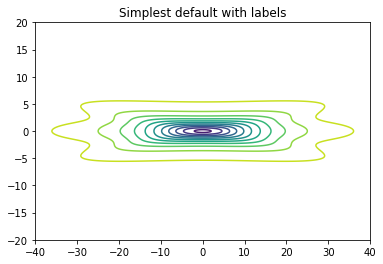

In [16]:
# https://matplotlib.org/stable/gallery/images_contours_and_fields/contour_demo.html

if isinstance(potentials, np.ndarray):
    potentials_for_contour_plotting = potentials.reshape((len(x), len(z))).T

    print(potentials_for_contour_plotting.shape)

    fig, ax = plt.subplots()
    cs      = ax.contour(x, z, potentials_for_contour_plotting, levels = 15)
    # ax.clabel(cs, inline=True, fontsize=10)
    ax.set_title('Simplest default with labels')

Something is not quite right here